In [5]:
!pip install librosa
!pip install tensorflow

In [6]:
import numpy as np
import pandas as pd

import os

from matplotlib import pyplot as plt
from matplotlib.pyplot import specgram

import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio

from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV

from tensorflow import keras
from keras import layers
from keras.layers import LSTM, Dense, Dropout
from keras.utils import to_categorical

In [7]:
%cd C:/Users/dandr/OneDrive/Documents/DanielAndrés/Academico/Maestria Sistemas/202202 Semestre/Aprendizaje de Maquinas/Proyecto

C:\Users\dandr\OneDrive\Documents\DanielAndrés\Academico\Maestria Sistemas\202202 Semestre\Aprendizaje de Maquinas\Proyecto


In [8]:
paths=[]
labels=[]

for dirname, _, filenames in os.walk('./Emotions/'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename[::-1].split('.')[0][::-1]
        name = dirname[::].split('/')[2]
        name_complete = name+'.'+label
        labels.append(name_complete.lower())

In [9]:
data = pd.DataFrame({'speech':paths,'label':labels})
data.sample(10)

,speech,label
4787,./Emotions/Fearful\1028_ITS_FEA_XX.wav,fearful.wav
7202,./Emotions/Happy\1054_TAI_HAP_XX.wav,happy.wav
10130,./Emotions/Sad\03-01-04-01-02-02-20.wav,sad.wav
12126,./Emotions/Sad\YAF_peg_sad.wav,sad.wav
6883,./Emotions/Happy\1031_WSI_HAP_XX.wav,happy.wav
11527,./Emotions/Sad\1080_MTI_SAD_XX.wav,sad.wav
4520,./Emotions/Fearful\1009_IEO_FEA_MD.wav,fearful.wav
9044,./Emotions/Neutral\1052_ITS_NEU_XX.wav,neutral.wav
559,./Emotions/Angry\1014_IEO_ANG_MD.wav,angry.wav
1638,./Emotions/Angry\1091_ITH_ANG_XX.wav,angry.wav


In [10]:
label_encoder = preprocessing.LabelEncoder()
data['label'] = data['label'].apply(lambda x: str(x).split('.wav')[0])
data['label']= label_encoder.fit_transform(data['label'])

In [11]:
data.head()

,speech,label
0,./Emotions/Angry\03-01-05-01-01-01-01.wav,0
1,./Emotions/Angry\03-01-05-01-01-01-02.wav,0
2,./Emotions/Angry\03-01-05-01-01-01-03.wav,0
3,./Emotions/Angry\03-01-05-01-01-01-04.wav,0
4,./Emotions/Angry\03-01-05-01-01-01-05.wav,0


In [12]:
data['label'].unique().tolist()

[0, 1, 2, 3, 4, 5, 6]

In [13]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [14]:
df_in=data['speech']

In [15]:
def get_features(df_in):
  features=[]
  for index in range(0,len(df_in)):
      print(index/len(df_in)*100)
      filename = df_in[index]
      y, sr = librosa.load(filename,duration=3,offset=0.5)
      hop_length = 512 #the default spacing between frames
      n_fft = 12816 #number of samples
      datal = np.array([padding(librosa.feature.mfcc(y,n_fft=n_fft,hop_length=hop_length,n_mfcc=40),40,400)])
      features.append(datal)
      output=np.concatenate(features,axis=0)
  return(np.array(output))

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
X=get_features(df_in)

0.0
0.00781372089388967
0.01562744178777934
0.02344116268166901
0.03125488357555868
0.039068604469448355
0.04688232536333802
0.05469604625722769
0.06250976715111736
0.07032348804500703
0.07813720893889671
0.08595092983278638
0.09376465072667604
0.10157837162056572
0.10939209251445538
0.11720581340834506
0.12501953430223472
0.13283325519612438
0.14064697609001406
0.14846069698390374
0.15627441787779342
0.16408813877168307
0.17190185966557275
0.1797155805594624
0.1875293014533521
0.19534302234724177
0.20315674324113145
0.21097046413502107
0.21878418502891075
0.22659790592280044
0.23441162681669012
0.24222534771057977
0.25003906860446945
0.2578527894983591
0.26566651039224876
0.27348023128613846
0.2812939521800281
0.2891076730739178
0.2969213939678075
0.30473511486169713
0.31254883575558684
0.32036255664947644
0.32817627754336615
0.3359899984372558
0.3438037193311455
0.35161744022503516
0.3594311611189248
0.3672448820128145
0.3750586029067042
0.38287232380059383
0.39068604469448354
0.3984

In [19]:
np.save('X_lstm.npy', X)


In [20]:
X.shape

(12798, 40, 400)

In [21]:
X = np.array((X-np.min(X))/(np.max(X)-np.min(X)))
X = X/np.std(X)

In [22]:
y = np.asarray(data['label'])
np.save('y.npy', y)

In [23]:
y=to_categorical(y)

In [24]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [25]:
print(f'Dimensiones mfcc:{X.shape}')
print(f'Dimensiones label:{y.shape}')

Dimensiones mfcc:(12798, 40, 400)
Dimensiones label:(12798, 7)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=123)

In [27]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('X_val.npy', X_val)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('y_val.npy', y_val)

In [28]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [32]:
np.save('y_LSTM.npy', y)

In [29]:
input_shape=(40,400)
model = keras.Sequential()
model.add(LSTM(40,input_shape=input_shape))
model.add(Dropout(0.1))
model.add(Dense(30, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                70560     
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 30)                1230      
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0

In [30]:
model.compile(optimizer='adam',loss='CategoricalCrossentropy',metrics=['acc'])

In [31]:
history = model.fit(X_train, y_train, epochs=100, batch_size=72,validation_data=(X_val, y_val))

Epoch 1/100
128/128 [==============================] - 13s 45ms/step - loss: 1.9291 - acc: 0.1594 - val_loss: 1.9050 - val_acc: 0.1801
Epoch 2/100
128/128 [==============================] - 4s 34ms/step - loss: 1.9091 - acc: 0.1678 - val_loss: 1.8961 - val_acc: 0.1671
Epoch 3/100
128/128 [==============================] - 4s 33ms/step - loss: 1.9039 - acc: 0.1675 - val_loss: 1.8912 - val_acc: 0.1671
Epoch 4/100
128/128 [==============================] - 5s 38ms/step - loss: 1.9027 - acc: 0.1690 - val_loss: 1.8911 - val_acc: 0.1706
Epoch 5/100
128/128 [==============================] - 5s 35ms/step - loss: 1.9023 - acc: 0.1636 - val_loss: 1.8905 - val_acc: 0.1671
Epoch 6/100
128/128 [==============================] - 4s 35ms/step - loss: 1.9002 - acc: 0.1709 - val_loss: 1.8899 - val_acc: 0.1706
Epoch 7/100
128/128 [==============================] - 4s 34ms/step - loss: 1.9003 - acc: 0.1576 - val_loss: 1.8887 - val_acc: 0.1706
Epoch 8/100
128/128 [==============================] - 5s 36m

In [ ]:
y_pred_test=model.predict(X_test)

40/40 [==============================] - 2s 13ms/step


In [ ]:
y_pred_test

array([[0.17019689, 0.14478563, 0.15990666, ..., 0.1414584 , 0.16621988,
        0.04889098],
       [0.17019689, 0.14478563, 0.15990666, ..., 0.1414584 , 0.16621988,
        0.04889098],
       [0.17019689, 0.14478563, 0.15990666, ..., 0.1414584 , 0.16621988,
        0.04889098],
       ...,
       [0.17019689, 0.14478563, 0.15990666, ..., 0.1414584 , 0.16621988,
        0.04889098],
       [0.17019689, 0.14478563, 0.15990666, ..., 0.1414584 , 0.16621988,
        0.04889098],
       [0.17019689, 0.14478563, 0.15990666, ..., 0.1414584 , 0.16621988,
        0.04889098]], dtype=float32)

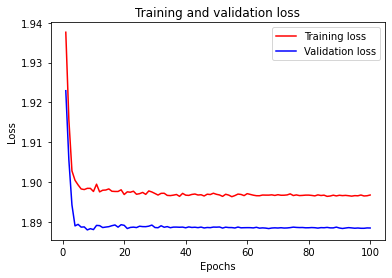

In [ ]:
## Plotting the training and validation loss:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [ ]:
y_pred=np.argmax(y_pred_test,axis=1)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

0.17109375
              precision    recall  f1-score   support

           0       0.17      1.00      0.29       219
           1       0.00      0.00      0.00       182
           2       0.00      0.00      0.00       218
           3       0.00      0.00      0.00       215
           4       0.00      0.00      0.00       181
           5       0.00      0.00      0.00       217
           6       0.00      0.00      0.00        48

    accuracy                           0.17      1280
   macro avg       0.02      0.14      0.04      1280
weighted avg       0.03      0.17      0.05      1280



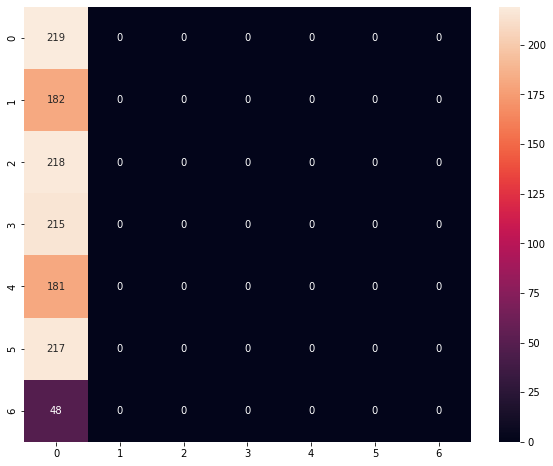

In [ ]:
print(accuracy_score(y_true=np.argmax(y_test,axis=1),y_pred=np.argmax(y_pred_test,axis=1)))
print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred_test,axis=1))) 
matrizr = confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred_test,axis=1))
plt.figure(figsize=(10,8))
sns.heatmap(matrizr, annot=True, fmt="d");

In [ ]:
import pickle
pickle.dump(model, open('LTSM.model','wb'))

NameError: name 'model' is not defined